In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as Dataset
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [44]:
NUM_EPOCH = 10
NUM_CLASSES = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.01

### Dataset

In [45]:
#Download the dataset
train_dataset = Dataset.EMNIST(root="./data", train=True, transform=Transforms.ToTensor(), split="mnist", download=True)
test_dataset = Dataset.EMNIST(root="./data", train=False, transform=Transforms.ToTensor(), split="mnist", download=True)

In [63]:
print(len(train_dataset))
print(len(test_dataset))
type(train_dataset)

60000
10000


torchvision.datasets.mnist.EMNIST

In [46]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [47]:
# Normalize the dataset
mean = 0.0
std = 0.0
num_samples = 0


for data, lbls in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f'{mean=}; {std=}; {num_samples=}')

normalize_transform = Transforms.Normalize(mean=mean, std=std)

train_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])

test_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])



mean=tensor([0.1733]); std=tensor([0.3256]); num_samples=60000


In [48]:
mean = [0.1751]
std = [0.3267]
num_samples=112800

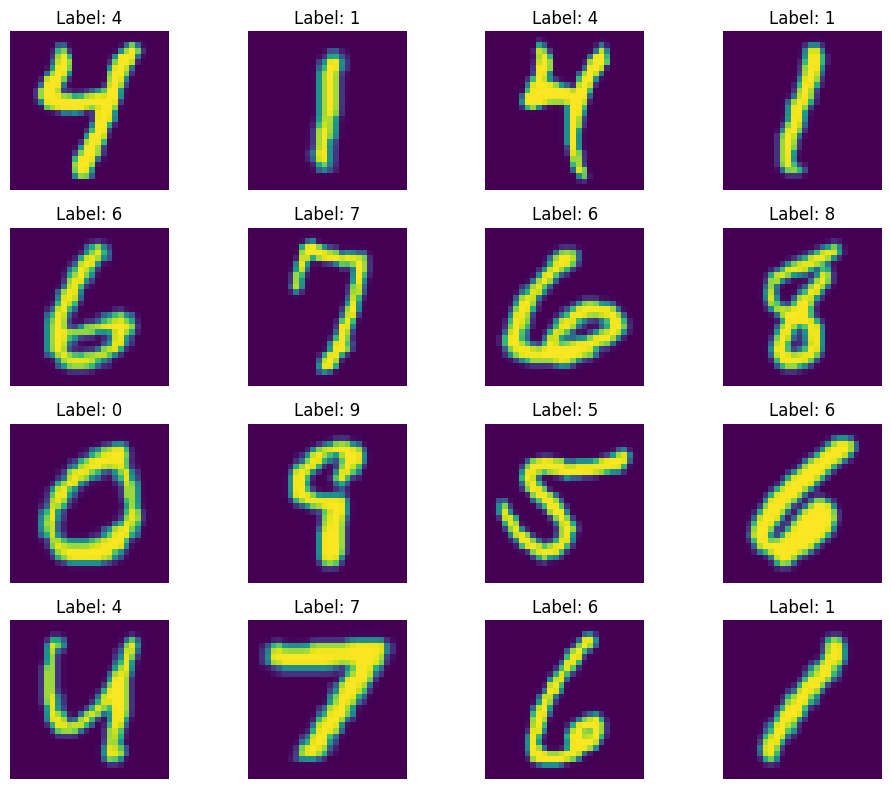

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
axes = axes.ravel()

for i in range(16):
    image, label = train_dataset[i]
    
    image = image.numpy().transpose((2, 1, 0))
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [50]:
for data, label in train_loader:
    print("Data shape:", data.shape)
    
    print("Label:", label)
    break

Data shape: torch.Size([64, 1, 28, 28])
Label: tensor([4, 9, 5, 0, 6, 8, 1, 3, 2, 8, 9, 6, 7, 8, 5, 4, 4, 8, 8, 4, 0, 5, 3, 8,
        7, 9, 0, 3, 9, 7, 6, 3, 4, 7, 9, 1, 8, 3, 0, 2, 8, 3, 3, 5, 5, 5, 0, 1,
        4, 9, 3, 2, 5, 6, 7, 8, 1, 1, 9, 0, 9, 1, 7, 8])


number of classes 10


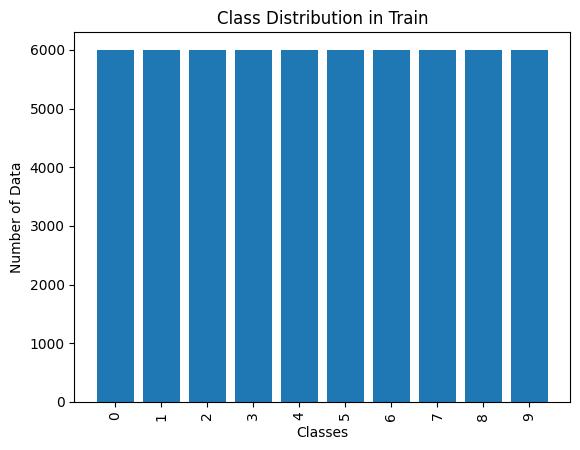

In [51]:
class_counts = {}

for values, labels in train_loader:
    for label in labels:
        if label.item() in class_counts:
            class_counts[label.item()] += 1
        else:
            class_counts[label.item()] = 1

classes = list(class_counts.keys())
counts = list(class_counts.values())
print(f'number of classes {len(classes)}')

NUM_CLASSES = len(classes)

# Plotting graph
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Data')
plt.title('Class Distribution in Train')
plt.xticks(classes)
plt.xticks(rotation=90)
plt.show()

In [52]:
VGG16 = [64, 64, 'M', 128,128,'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
VGG1 = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M']

In [53]:
class VGGNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, architecture=VGG16):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096), # size of feature map at end is 7*7
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,num_classes)
        )
        self.softMax = nn.Softmax(dim=1) # not sure


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [54]:
class VGGNet1(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, architecture=VGG1):
        super(VGGNet1, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(architecture)
        self.fcs = nn.Sequential(
            nn.Linear(2304, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048,num_classes)
        )
        # self.softMax = nn.Softmax(dim=1)


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        # out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [55]:
model = VGGNet1(architecture=VGG1,in_channels=1, num_classes=NUM_CLASSES).to(device)
model

VGGNet1(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [56]:
def test():
    x = torch.randn(2, 1, 28, 28)
    print(x.shape)

    result = model(x.to(device))
    return result

fp = test()
fp.sum()

torch.Size([2, 1, 28, 28])


tensor(-0.0077, device='cuda:0', grad_fn=<SumBackward0>)

In [57]:
def train(model, epochs, criterion, optimizer, scheduler, train_loader, test_loader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0

        print(f"Epoch: {i + 1}")

        for images, targets in tqdm(train_loader, desc= "Train\t"):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)
            
        scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(running_correct / total)

        running_test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():

            for images, targets in tqdm(test_loader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_test_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_test_loss / len(test_loader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), './models/model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")


    return train_losses, train_acc, test_losses, test_acc
            

In [58]:
# optimizer and loss and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH, eta_min=0.001)

In [59]:
train_losses, train_acc, test_losses, test_acc = train(model,NUM_EPOCH,optimizer=optimizer, criterion=criterion, scheduler=scheduler, train_loader=train_loader, test_loader=test_loader )

Epoch: 1


Train	:   1%|          | 6/938 [00:00<00:17, 53.67it/s]

Test	: 100%|██████████| 157/157 [00:00<00:00, 165.78it/s]


Train Loss: 1.335, Train Acc: 0.732, Test Loss: 0.225, Test Acc: 0.943

Epoch: 2


Test	: 100%|██████████| 157/157 [00:00<00:00, 165.81it/s]


Train Loss: 0.201, Train Acc: 0.954, Test Loss: 0.166, Test Acc: 0.968

Epoch: 3


Test	: 100%|██████████| 157/157 [00:00<00:00, 165.98it/s]


Train Loss: 0.140, Train Acc: 0.968, Test Loss: 0.196, Test Acc: 0.961

Epoch: 4


Test	: 100%|██████████| 157/157 [00:00<00:00, 161.74it/s]


Train Loss: 0.118, Train Acc: 0.974, Test Loss: 0.098, Test Acc: 0.976

Epoch: 5


Test	: 100%|██████████| 157/157 [00:00<00:00, 163.26it/s]


Train Loss: 0.092, Train Acc: 0.980, Test Loss: 0.065, Test Acc: 0.985

Epoch: 6


Test	: 100%|██████████| 157/157 [00:00<00:00, 164.48it/s]


Train Loss: 0.071, Train Acc: 0.984, Test Loss: 0.065, Test Acc: 0.985

Epoch: 7


Test	: 100%|██████████| 157/157 [00:01<00:00, 132.60it/s]


Train Loss: 0.050, Train Acc: 0.988, Test Loss: 0.044, Test Acc: 0.989

Epoch: 8


Test	: 100%|██████████| 157/157 [00:00<00:00, 166.79it/s]


Train Loss: 0.037, Train Acc: 0.991, Test Loss: 0.043, Test Acc: 0.990

Epoch: 9


Test	: 100%|██████████| 157/157 [00:00<00:00, 162.35it/s]


Train Loss: 0.030, Train Acc: 0.993, Test Loss: 0.039, Test Acc: 0.991

Epoch: 10


Test	: 100%|██████████| 157/157 [00:00<00:00, 158.13it/s]


Train Loss: 0.023, Train Acc: 0.994, Test Loss: 0.036, Test Acc: 0.992



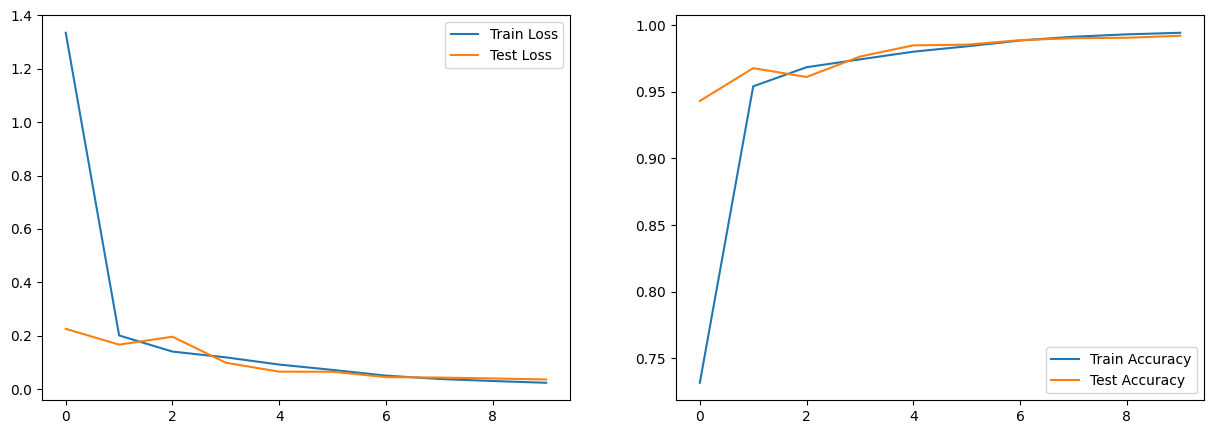

In [60]:
def plot_graphs(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Test Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Test Accuracy")
    plt.legend()
    plt.show()

plot_graphs(train_losses, train_acc, test_losses, test_acc)